# AXL RNAseq analysis

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from msresist.pre_processing import preprocessing, VarianceFilter
from msresist.plsr import plotR2YQ2Y
from msresist.figures.common import import_phenotype_data, formatPhenotypesForModeling
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.metrics import r2_score

In [2]:
# Set plotting format
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

## 0. Import and Preprocess RNAseq data

In [3]:
rna = pd.read_feather("msresist/data/RNAseq/AXLmutants_RNAseq_merged.feather").iloc[:, 1:]
idsT = pd.read_csv("msresist/data/RNAseq/transcripts_to_genes.csv")
ids = dict(zip(idsT["ENSEMBL1"], idsT["SYMBOL"]))
rna.insert(0, "Cell Lines", [s[:3] if "M1" in s else s[:2] for s in rna["Cell Line"]])
rna.insert(1, "Treatment", [s[-1] if s[-1] == "E" in s else s[-2:] for s in rna["Cell Line"]])
rna = rna.drop("Cell Line", axis=1)
XIDX = np.any(rna.iloc[:, 2:].values > 10, axis=0)
rna_f = rna.iloc[:, [True, True] + list(XIDX)]
rna_f.iloc[:, 2:] = pd.DataFrame(StandardScaler().fit_transform(rna_f.iloc[:, 2:]))
rna_f.columns = ["Cell Lines", "Treatment"] + [ids[g] if g in ids.keys() else g for g in list(rna_f.columns[2:])]
rna_f = rna_f.set_index("Cell Lines").T
rna_f = rna_f.rename(columns={"KD":"KD", "PC9":"WT", "M4": "Y634F", "M5":"Y643F", "M7":"Y698F", "M10":"Y726F", "M11":"Y750F", "M15":"Y821F"}).T.reset_index()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1851: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [7]:
# def filter_by_EvEAvar(rna_f, savefig=False, perCut=50):
#     rnaE = rna_f[rna_f["Treatment"] == "E"].sort_values(by="Cell Lines")
#     rnaEA = rna_f[(rna_f["Treatment"] == "EA") | (rna_f["Cell Lines"] == "KO") & ~(rna_f["Treatment"] == "UT")].sort_values(by="Cell Lines")
#     ssd = []
#     for ii in range(2, rnaE.shape[1]):
#         ssd.append(np.sum(np.square(rnaEA.iloc[:, ii].values - rnaE.iloc[:, ii].values)))
#     rna_fEA = rna_f.iloc[:, [True, True] + list(ssd >= np.percentile(ssd, perCut))]
#     rna_fEA = rna_fEA[rna_fEA["Treatment"] != "UT"].T
#     rna_fEA.columns = [c + "-" + t for c, t in list(zip(rna_fEA.iloc[0, :], rna_fEA.iloc[1, :]))]
#     rna_fEA = rna_fEA.iloc[2:, :]
#     if savefig:
#         rna_fEA.to_csv("msresist/WGCNA/WGCNA_input_Filtered_Abundance_and_EvA.txt", sep="\t")        
#     return rna_fEA

# rna_fEA = filter_by_EvEAvar(rna_f, savefig=True, perCut=50)

## 1. Targeted Pathways / Kinases

In [72]:
rna_f["bHLHa38"]

KeyError: 'bHLHa38'

<AxesSubplot:xlabel='Cell Lines', ylabel='AHNAK'>

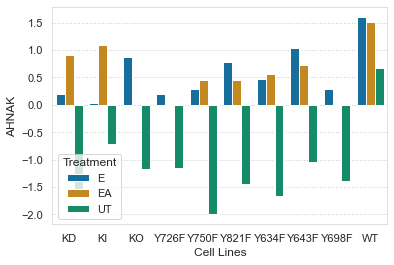

In [74]:
ccn1 = pd.DataFrame(rna_f["AHNAK"]).reset_index()
sns.barplot(data=ccn1, x="Cell Lines", y="AHNAK", hue="Treatment")

<AxesSubplot:xlabel='Cell Lines', ylabel='FLNB'>

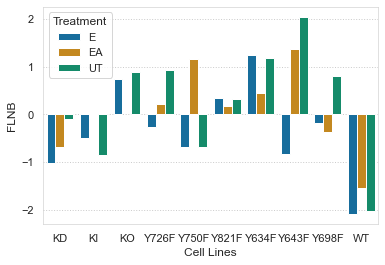

In [83]:
ccn1 = pd.DataFrame(rna_f["FLNB"]).reset_index().iloc[:, :3]
sns.barplot(data=ccn1, x="Cell Lines", y="FLNB", hue="Treatment")

## 2. WGCNA Modules

In [9]:
# eg = pd.read_csv("msresist/WGCNA/output/final-eigengenes.csv").set_index("Module")
# memberships = pd.read_csv("msresist/WGCNA/output/final-membership.csv")

# eg = eg.T.reset_index()
# eg = eg.rename_axis("", axis="columns")
# eg.insert(0, "Cell Lines", [s[:3] if "M1" in s else s[:2] for s in eg["index"]])
# eg.insert(1, "Treatment", [s[-1] if s[-1] == "E" in s else s[-2:] for s in eg["index"]])
# eg = eg.drop("index", axis=1)
# eg.head()

In [10]:
# egF = eg.sort_values(by="Treatment").set_index(["Cell Lines", "Treatment"])
# sns.clustermap(egF.T, cmap="bwr", robust=True, col_cluster=True)

### Use MS data to predict Modules 

TODO: Filter modules based on variance between E v EA conditions. Maybe only WT.

In [11]:
# # Import siganling data
# ms = preprocessing(AXLm_ErlAF154=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)
# ms = ms.rename(columns={"PC9 A":"WT", "KO A":"KO", "Kd A":"KDead", "KI A":"KI","M4 A": "Y634F", "M5 A":"Y643F", "M7 A":"Y698F", "M10 A":"Y726F", "M11 A":"Y750F", "M15 A":"Y821F"})
# d = ms.select_dtypes(include=['float64']).T
# i = ms.select_dtypes(include=['object'])

In [12]:
# ddmc = MassSpecClustering(i, n_components=5, SeqWeight=2, distance_method="PAM250", random_state=5).fit(d)
# centers = pd.DataFrame(ddmc.transform())
# centers.index = d.index

In [13]:
# egEA = eg[(eg["Treatment"] == "EA") | (eg["Cell Lines"] == "KO")].set_index("Cell Lines").T
# egEA = egEA.rename(columns={"KD":"KDead", "M4": "Y634F", "M5":"Y643F", "M7":"Y698F", "M10":"Y726F", "M11":"Y750F", "M15":"Y821F"})
# egEA = egEA[list(centers.index)].T.drop("Treatment", axis=1).T
# egEA = egEA.rename_axis("Module", axis="columns").astype(float)

In [14]:
# egEA_f = VarianceFilter(egEA, list(egEA.columns), axis=1, varCut=0.01).T
# sns.clustermap(egEA, cmap="bwr", robust=True, figsize=(6, 5), method="centroid")
# sns.clustermap(egEA_f.T, cmap="bwr", robust=True, figsize=(6, 5), method="centroid")

In [15]:
# _, ax = plt.subplots(1, 1)
# plotR2YQ2Y(ax, PLSRegression(n_components=2), egEA_f, centers, b=6, color="darkblue", title=False)

In [16]:
# reg = MultiTaskLassoCV(cv=10, eps=1e-5).fit(egEA_f, centers)
# r2_score(centers, reg.predict(egEA_f))

### Use Modules to predict Phenotypes

In [17]:
# cv = import_phenotype_data(phenotype="Cell Viability")
# red = import_phenotype_data(phenotype="Cell Death")
# sw = import_phenotype_data(phenotype="Migration")
# c = import_phenotype_data(phenotype="Island")
# y = formatPhenotypesForModeling(cv, red, sw, c)
# y = y[y["Treatment"] == "A/E"].drop("Treatment", axis=1).set_index("Lines")

In [18]:
# _, ax = plt.subplots(1, 1)
# plotR2YQ2Y(ax, PLSRegression(n_components=2), egEA_f, y, b=6, color="darkblue", title=False)

In [19]:
# reg = MultiTaskLassoCV(cv=10, eps=1e-5).fit(egEA_f, y)
# r2_score(y, reg.predict(egEA_f))

## 3. PCA

1. Preprocess raw data based on abundance and variance. Make sure AXL is present
2. Make another file version filtering only extremely low transcripts out for GSEA
3. Run PCA
    - Plot Scores
    - Try to predict using Scores of PCA with EA data only

In [20]:
from sklearn.decomposition import PCA
from msresist.pca import pca_dfs, plotPCA_scoresORloadings

### PCA Scores

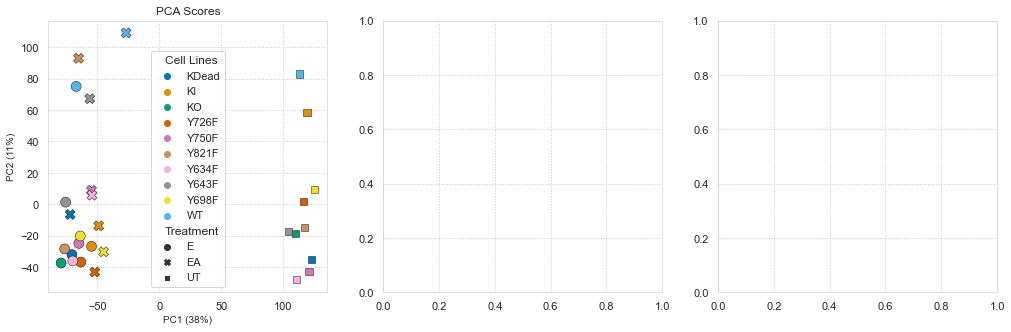

In [37]:
_, ax = plt.subplots(1, 3, figsize=(17, 5))

# Full PCA
rna_f = rna_f.set_index("Cell Lines").rename(index={"KD":"KDead", "PC9":"WT", "M4": "Y634F", "M5":"Y643F", "M7":"Y698F", "M10":"Y726F", "M11":"Y750F", "M15":"Y821F"}).reset_index()
rna_f.iloc[:, 2:] = rna_f.iloc[:, 2:].astype(float)
plotPCA_scoresORloadings(ax[0], rna_f, 2, ["Cell Lines", "Treatment"], rna_f.columns[2:], hue_scores="Cell Lines", style_scores="Treatment", legendOut=False, plot="scores")

# EA PCA
rna_fEA = rna_f[(rna_f["Treatment"] == "EA") | (rna_f["Cell Lines"] == "KO") & ~(rna_f["Treatment"] == "UT")].drop("Treatment", axis=1).set_index("Cell Lines")
rna_fEA = rna_fEA.rename(index={"KD":"KDead", "PC9":"WT","M4": "Y634F", "M5":"Y643F", "M7":"Y698F", "M10":"Y726F", "M11":"Y750F", "M15":"Y821F"}).T
# rna_fEA = rna_fEA[list(centers.index)].T.reset_index()
# plotPCA_scoresORloadings(ax[1], rna_fEA, 2, ["Cell Lines"], rna_fEA.columns[1:], hue_scores="Cell Lines", legendOut=False, plot="scores")
# plotPCA_scoresORloadings(ax[2], rna_fEA.set_index("Cell Lines").drop("WT").reset_index(), 2, ["Cell Lines"], rna_fEA.columns[1:], hue_scores="Cell Lines", legendOut=False, plot="scores")

In [69]:
n_components = 4
scores_ind = ["Cell Lines"]
loadings_ind = rna_fEA.columns[2:]

ppEA = PCA(n_components=n_components)
dScor_EA = ppEA.fit_transform(rna_fEA.select_dtypes(include=["float64"]))
dLoad_EA = ppEA.components_
dScor_EA, dLoad_EA = pca_dfs(dScor_EA, dLoad_EA, rna_fEA, n_components, scores_ind, loadings_ind)
scoresEA = dScor_EA.set_index("Cell Lines")
scoresEA.iloc[:, :] = StandardScaler().fit_transform(dScor_EA.set_index("Cell Lines"))
varExp = np.round(ppEA.explained_variance_ratio_, 2)

### 4. GSEA
#### 4.1 Standard

In [27]:
import gseapy as gp

In [38]:
st_gsea_d = rna_f[rna_f["Treatment"] != "UT"]
st_gsea_d.insert(0, "Sample", [c + "_" + t for c, t in list(zip(list(st_gsea_d["Cell Lines"]), list(st_gsea_d["Treatment"])))])
st_gsea_d = st_gsea_d.drop(["Cell Lines", "Treatment"], axis=1).set_index("Sample").T
st_gsea_d = st_gsea_d[~st_gsea_d.index.duplicated()]
samples = list(rna_f["Treatment"][rna_f["Treatment"] != "UT"])

In [41]:
print(samples)
st_gsea_d

['E', 'EA', 'E', 'EA', 'E', 'E', 'EA', 'E', 'EA', 'E', 'EA', 'E', 'EA', 'E', 'EA', 'E', 'EA', 'E', 'EA']


Sample,KDead_E,KDead_EA,KI_E,KI_EA,KO_E,Y726F_E,Y726F_EA,Y750F_E,Y750F_EA,Y821F_E,Y821F_EA,Y634F_E,Y634F_EA,Y643F_E,Y643F_EA,Y698F_E,Y698F_EA,WT_E,WT_EA
GPX1,-0.952666,-0.804980,0.180572,-0.831976,0.245796,-0.619947,-0.955099,-1.150020,-1.097452,-1.203234,-1.669222,0.090009,-0.714651,0.369980,-0.297270,-0.825816,-0.888425,1.217476,2.446660
PKD1L2,1.111373,0.787675,0.851830,0.656814,1.369108,0.218851,0.433419,0.307076,0.445966,1.208578,1.020740,0.655812,1.594462,1.091235,0.609850,0.595607,0.470614,-0.460967,-1.250536
ENST00000622053.4,-0.860961,-0.840119,-0.608375,-0.748983,-0.832326,-0.881863,-0.666333,-0.721272,-0.708882,-0.859717,-0.840365,-0.522139,-0.554901,-0.620171,-0.679258,-0.769428,-0.776988,-0.504634,-0.472856
IGLV5-52,-1.444459,0.859360,-0.146834,-0.849833,0.571617,0.085337,0.213432,0.794614,0.282615,-0.691153,-0.548304,2.222123,-0.210512,0.102044,-0.987172,1.612156,2.545853,-0.346304,0.110260
IGLV1-51,0.460198,-0.110828,-1.070584,-1.146700,0.042593,0.358210,-0.380440,-0.939781,-0.349307,-0.274284,0.441239,-0.558065,-0.545729,1.422977,-0.030150,3.376245,-0.599603,-0.241108,1.183253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC139769.3,0.295438,0.931416,-0.893167,0.858279,1.179667,-0.643467,-0.030193,-0.755220,0.716153,1.295603,-1.113428,-0.717046,-0.542005,3.147534,0.413982,-0.235253,0.826602,0.173935,-1.381398
AC112907.2,-1.015461,0.231582,-1.381813,-0.301275,-0.417754,0.207009,-0.173334,-0.405839,0.982715,-0.314665,-1.304193,-0.073679,-1.128727,-0.116016,-0.493231,-1.092383,0.090699,-1.422526,-1.442750
AL450124.1,1.061606,0.245118,0.642248,0.603356,1.152630,0.909654,0.976740,0.831856,0.683840,0.747024,0.156124,0.209961,0.618425,1.501152,0.218542,1.391751,0.517825,-0.068899,0.490588
PMS2P6,-0.035939,0.079962,0.301239,0.190922,0.295447,-0.632961,-1.254310,-0.591555,1.986094,1.155283,1.237447,1.174188,-0.248537,0.303420,2.699462,0.050554,-0.996802,-0.094352,1.664239


In [115]:
# GO
gs_res = gp.gsea(data=st_gsea_d, 
                 gene_sets='GO_Biological_Process_2021', 
                 cls= samples, 
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype',
                 permutation_num=100, 
                 outdir='GSEA_standard_results/GSEA_EvsEA_GO21',
                 method='signal_to_noise',
                 processes=4, seed= 7,
                 format='png')

In [116]:
# WP
gs_res = gp.gsea(data=st_gsea_d, 
                 gene_sets='WikiPathway_2021_Human',
                 cls= samples, 
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype',
                 permutation_num=100,
                 outdir='GSEA_standard_results/GSEA_EvsEA_WP21',
                 method='signal_to_noise',
                 processes=4, seed= 7,
                 format='png')

In [117]:
# OGS
gs_res = gp.gsea(data=st_gsea_d, 
                 gene_sets='MSigDB_Oncogenic_Signatures',
                 cls= samples, 
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype',
                 permutation_num=100,
                 outdir='GSEA_standard_results/GSEA_EvsEA_OGS21',
                 method='signal_to_noise',
                 processes=4, seed= 7,
                 format='png')

In [114]:
# KEGG
gs_res = gp.gsea(data=st_gsea_d, 
                 gene_sets='KEGG_2021_Human',
                 cls= samples, 
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype',
                 permutation_num=100,
                 outdir='GSEA_standard_results/GSEA_EvsEA_KEGG21',
                 method='signal_to_noise',
                 processes=4, seed= 7,
                 format='png')

#### 4.1 GSEA with EA PCA loadings
#### 4.1.1 Ranked PCA loadings

In [28]:
dLoad_EA = dLoad_EA.reset_index()
dLoad_EA = dLoad_EA.rename(columns={"index": "Gene"})
rankPCS = dLoad_EA.iloc[:, 1:].abs().sum(axis=1)
dLoad_EA["Sum"] = rankPCS
PCrank = rankPCS.sort_values(ascending=False).index

LoadR_pcs = dLoad_EA.iloc[PCrank, :]
LoadR_pcs = LoadR_pcs[["Gene", "Sum"]].set_index("Gene")
LoadR_pcs = LoadR_pcs[~LoadR_pcs.index.duplicated()]
LoadR_pcs.iloc[:, :] = StandardScaler().fit_transform(LoadR_pcs)

In [31]:
# GO
pre_res_EA = gp.prerank(rnk=LoadR_pcs, gene_sets='GO_Biological_Process_2021',
                     processes=4,
                     permutation_num=100,
                     outdir='GSEA_ranked_results/GO/PCA_PCs_EA_GO21', format='png', seed=6)

# terms = pre_res.res2d.index
# gseaplot(rank_metric=pre_res.ranking, term=terms[4], **pre_res.results[terms[4]])

In [32]:
# WikiPathways
pre_res_EA = gp.prerank(rnk=LoadR_pcs, gene_sets='WikiPathway_2021_Human',
                     processes=4,
                     permutation_num=100,
                     outdir='GSEA_ranked_results/WP/PCA_PCs_EA_WP21', format='png', seed=6)

In [33]:
# OncoPathways
pre_res_EA = gp.prerank(rnk=LoadR_pcs, gene_sets='MSigDB_Oncogenic_Signatures',
                     processes=4,
                     permutation_num=100,
                     outdir='GSEA_ranked_results/OGS/PCA_PCs_EA_OGS', format='png', seed=6)

#### 4.1.2 PCA loadings ranked by AXL MS

In [29]:
MSrank = ms.iloc[:, 6:].set_index("Gene").abs().sum(axis=1).sort_values(ascending=False)
MSrank = MSrank[~MSrank.index.duplicated()]
MSrank = MSrank.drop(['MCAM', 'ALB', 'PAG1', 'TNS1', 'DYRK3', 'EPHA5', 'MAPK10', 'SEPT2', 'TEC', 'PARD3B'])
dLoad_EA = dLoad_EA.sort_values(by="Sum", ascending=False).set_index("Gene")
dLoad_EA = dLoad_EA[~dLoad_EA.index.duplicated()]
dLoad_msR = dLoad_EA.loc[MSrank.index]
dLoad_msR = dLoad_msR.reset_index()[["Gene", "Sum"]].set_index("Gene")
dLoad_msR.iloc[:, :] = StandardScaler().fit_transform(dLoad_msR)

In [43]:
# GO
pre_res_MS_go = gp.prerank(rnk=dLoad_msR, gene_sets='GO_Biological_Process_2021',
                     processes=4,
                     permutation_num=100,
                     outdir='GSEA_ranked_results/GO/PCA_MS_EA_GO21', format='png', seed=6)

In [44]:
# WP
pre_res_MS_wp = gp.prerank(rnk=dLoad_msR, gene_sets='WikiPathway_2021_Human',
                     processes=4,
                     permutation_num=100,
                     outdir='GSEA_ranked_results/WP/PCA_MS_EA_WP21', format='png', seed=6)

In [45]:
# OGS
pre_res_MS_ogs = gp.prerank(rnk=dLoad_msR, gene_sets='MSigDB_Oncogenic_Signatures',
                     processes=4,
                     permutation_num=100,
                     outdir='GSEA_ranked_results/OGS/PCA_MS_EA_OGS', format='png', seed=6)

#### 4.1.3 PCA loadings ranked by PC1

In [30]:
dPC1 = dLoad_EA.reset_index().sort_values(by="PC1", ascending=False)[["Gene", "PC1"]]
dPC1 = dPC1[~dPC1.index.duplicated()].set_index("Gene")
dPC1.iloc[:, :] = StandardScaler().fit_transform(dPC1)

In [52]:
#GO
pre_res_pc1GO = gp.prerank(rnk=dPC1, gene_sets='GO_Biological_Process_2021',
                     processes=4,
                     permutation_num=100,
                     outdir='GSEA_ranked_results/GO/PCA_PC1_EA_GO21', format='png', seed=6)

In [53]:
# WP
pre_res_pc1WP = gp.prerank(rnk=dPC1, gene_sets='WikiPathway_2021_Human',
                     processes=4,
                     permutation_num=100,
                     outdir='GSEA_ranked_results/WP/PCA_PC1_EA_WP21', format='png', seed=6)

In [54]:
# OGS
pre_res_pc1OGS = gp.prerank(rnk=dPC1, gene_sets='MSigDB_Oncogenic_Signatures',
                     processes=4,
                     permutation_num=100,
                     outdir='GSEA_ranked_results/OGS/PCA_PC1_EA_OGS', format='png', seed=6)

### 4.3 GSEA with Full PCA Loadings 

In [31]:
ppF = PCA(n_components=n_components)
dScor_F = ppF.fit_transform(rna_f.select_dtypes(include=["float64"]))
dLoad_F = ppF.components_
dScor_F, dLoad_F = pca_dfs(dScor_F, dLoad_F, rna_f, n_components, scores_ind, loadings_ind)
scoresF = dScor_F.set_index("Cell Lines")
scoresF.iloc[:, :] = StandardScaler().fit_transform(dScor_F.set_index("Cell Lines"))
varExp = np.round(ppF.explained_variance_ratio_, 2)

#### 4.3.1 Ranked by all PCs 

In [32]:
dLoad_F = dLoad_F.reset_index()
dLoad_F = dLoad_F.rename(columns={"index": "Gene"})
rankPCS = dLoad_F.iloc[:, 1:].abs().sum(axis=1)
dLoad_F["Sum"] = rankPCS
PCrank = rankPCS.sort_values(ascending=False).index

LoadF_pcs = dLoad_F.iloc[PCrank, :]
LoadF_pcs = LoadF_pcs[["Gene", "Sum"]].set_index("Gene")
LoadF_pcs = LoadF_pcs[~LoadF_pcs.index.duplicated()]
LoadF_pcs.iloc[:, :] = StandardScaler().fit_transform(LoadF_pcs)

In [33]:
# GO
pre_res_F_go = gp.prerank(rnk=LoadF_pcs, gene_sets='GO_Biological_Process_2021',
                     processes=4,
                     permutation_num=100,
                     outdir='GSEA_ranked_results/GO/PCA_Fpcs_GO21', format='png', seed=6)

In [34]:
# WP
pre_res_F_go = gp.prerank(rnk=LoadF_pcs, gene_sets='WikiPathway_2021_Human',
                     processes=4,
                     permutation_num=100,
                     outdir='GSEA_ranked_results/WP/PCA_PCs_F_WP21', format='png', seed=6)

In [35]:
# OGS
pre_res_pc1OGS = gp.prerank(rnk=LoadF_pcs, gene_sets='MSigDB_Oncogenic_Signatures',
                     processes=4,
                     permutation_num=100,
                     outdir='GSEA_ranked_results/OGS/PCA_PCs_F_OGS', format='png', seed=6)

#### 4.3.2 Full PCA loadings ranked by AXL MS

In [36]:
MSrankF = ms.iloc[:, 6:].set_index("Gene").abs().sum(axis=1).sort_values(ascending=False)
MSrankF = MSrankF[~MSrankF.index.duplicated()]
MSrankF = MSrankF.drop(['MCAM', 'ALB', 'PAG1', 'TNS1', 'DYRK3', 'EPHA5', 'MAPK10', 'SEPT2', 'TEC', 'PARD3B'])
dLoad_F = dLoad_F.sort_values(by="Sum", ascending=False).set_index("Gene")
dLoad_F = dLoad_F[~dLoad_F.index.duplicated()]
dLoad_msF = dLoad_F.loc[MSrankF.index]
dLoad_msF = dLoad_msF.reset_index()[["Gene", "Sum"]].set_index("Gene")
dLoad_msF.iloc[:, :] = StandardScaler().fit_transform(dLoad_msF)

In [37]:
# GO
pre_res_F_go = gp.prerank(rnk=dLoad_msF, gene_sets='GO_Biological_Process_2021',
                     processes=4,
                     permutation_num=100,
                     outdir='GSEA_ranked_results/GO/PCA_MS_F_GO21', format='png', seed=6)

In [38]:
# WP
pre_res_F_go = gp.prerank(rnk=dLoad_msF, gene_sets='WikiPathway_2021_Human',
                     processes=4,
                     permutation_num=100,
                     outdir='GSEA_ranked_results/WP/PCA_MS_F_WP21', format='png', seed=6)

In [39]:
# OGS
pre_res_pc1OGS = gp.prerank(rnk=dLoad_msF, gene_sets='MSigDB_Oncogenic_Signatures',
                     processes=4,
                     permutation_num=100,
                     outdir='GSEA_ranked_results/OGS/PCA_MS_F_OGS', format='png', seed=6)

### 4.4 Prep input data for ClusterProfiler

In [104]:
clusPro = pd.melt(rna_f, id_vars=["Cell Lines", "Treatment"], value_vars=rna_f.columns[2:], var_name="Gene", value_name="log(TPM)")
clusPro = clusPro.rename(columns={"Cell Lines":"Lines"})
clusPro = clusPro[~clusPro["Gene"].str.startswith("ENST0")].set_index(["Gene", "Treatment", "Lines"])
clusPro = clusPro[~clusPro.index.duplicated()]

# Filter based on signal
XIDX = list((clusPro["log(TPM)"] >= 1) | (clusPro["log(TPM)"] <= -1))
clusPro_f = clusPro.iloc[XIDX, :]
clusPro_f.to_csv("RNAseq_CLuPro_Filtered_Input.csv")


In [113]:
clusPro_f.to_csv("RNAseq_CLuPro_Filtered_Input.csv")

In [108]:
import mygene

clusPro_f = clusPro_f.reset_index()
mg = mygene.MyGeneInfo()
gg = mg.querymany(list(clusPro_f["Gene"]), scopes="symbol", fields="entrezgene", species="human", returnall=False, as_dataframe=True)
aa = dict(zip(list(gg.index), list(gg["entrezgene"])))
for ii in range(clusPro_f.shape[0]):
    clusPro_f.loc[ii, "Gene"] = aa[clusPro_f.loc[ii, "Gene"]]

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-33000...done.
querying 33001-34000...done.
querying 34001-35000...done.
queryin

### 4.5 GSEA of WGCNA clusters

In [ ]:
from gseapy.plot import gseaplot, dotplot, barplot

## 6. AXL Correlation Analysis